# Reading MS Word document

We read the document and create a .csv file with the list of paragaphs and their lengths

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TORCH_USE_CUDA_DSA'] = 'true'

In [12]:
docTitle = "22289.docx"
docFolder = '/mnt/d/3GPP/tsg_ran/AHG1_ITU_Coord/TSGRT_01/Docs'

## Solution 2: docx

This is a library that understands MS Word styles

In [16]:
# !pip install -q docx2python
from docx2python import docx2python
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer, PegasusTokenizer, PegasusForConditionalGeneration


In [ ]:
# extract docx content
doc_result = docx2python(docTitle, paragraph_styles = True, html=True)

In [ ]:
print(doc_result)

In [ ]:
# this part of the code identifies the section that contains the word "latency"
# and then extracts the lines that contain the word "latency" and all other lines in the same section
strSectionTitle = ""
dictSections = {}
listLatency = []
listLatencyLines = []
for oneLine in doc_result.text.split('\n'):
  if "<h" in oneLine:
    strSectionTitle = oneLine
    dictSections[strSectionTitle] = []

  if strSectionTitle != "":  
    dictSections[strSectionTitle].append(oneLine)

  if "latency" in oneLine: 
    listLatency.append(strSectionTitle)
    listLatencyLines.append(oneLine)


In [ ]:
# go through all the lines in the section that contains the word "latency"
for title in listLatency:
  if title in dictSections.keys():
    lstLines = dictSections[title]
    # join lines in the list to one long string
    strLines = ' '.join(lstLines)
    # print(strLines) but only 20 first characters
    print(strLines)

    summary = getSummaryBART(strLines)
    
    # summary = getSummaryDistilBart(strLines, 30)
    
    print(summary)
    
    print ("-----------------")


In [ ]:
model_name_bart = "knkarthick/MEETING-SUMMARY-BART-LARGE-XSUM-SAMSUM-DIALOGSUM-AMI"
tokenizer_bart = BartTokenizer.from_pretrained(model_name_bart)
model_bart = BartForConditionalGeneration.from_pretrained(model_name_bart).to('cuda')

def getSummaryBART(line):

    inputs = tokenizer_bart.encode("summarize: " + line, return_tensors="pt", max_length=1024, truncation=True).to('cuda')
    summary_ids = model_bart.generate(inputs, max_length=30, min_length=5, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
model_name_pegassus = "google/pegasus-xsum"
tokenizer_pegassus = PegasusTokenizer.from_pretrained(model_name_pegassus)
model_pegassus = PegasusForConditionalGeneration.from_pretrained(model_name_pegassus).to('cuda')

In [ ]:
def getSummaryPegasus(line):
    inputs = tokenizer_pegassus.encode("summarize: " + line, return_tensors="pt", max_length=1024, truncation=True).to('cuda')
    summary_ids = model_pegassus.generate(inputs, max_length=20, min_length=1, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_pegassus.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
model_name_fb = "nickmuchi/fb-bart-large-finetuned-trade-the-event-finance-summarizer"
tokenizer_fb = BartTokenizer.from_pretrained(model_name_fb)
model_fb = BartForConditionalGeneration.from_pretrained(model_name_fb).to('cuda:1')

def getSummaryBart2(line):
    inputs = tokenizer_fb.encode(line, return_tensors="pt", max_length=1024, truncation=True).to('cuda:1')
    summary_ids = model_fb.generate(inputs, max_length=150, min_length=5, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_fb.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
model_name_db = "sshleifer/distilbart-cnn-12-6"
tokenizer_db = BartTokenizer.from_pretrained(model_name_db)
model_db = BartForConditionalGeneration.from_pretrained(model_name_db).to('cuda')

def getSummaryDistilBart(line, length):
    inputs = tokenizer_db.encode(line, return_tensors="pt", max_length=1024, truncation=True).to('cuda')
    summary_ids = model_db.generate(inputs, max_length=length, min_length=5, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_db.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:

dictResults = {}
iCounter = 0

for eachLine in listLatencyLines:
    iCounter += 1
    summary = getSummaryBART(eachLine)
    summary2 = getSummaryDistilBart(eachLine)
    summary3 = getSummaryBart2(eachLine)
    summary4 = getSummaryPegasus(eachLine)
    # print(f'-- line: {eachLine} \nsummary Bart: {summary}\nsummary distBart: {summary2}\nsummary bart2: {summary3} \n')

    # print the number of items processed every 10 items
    if iCounter % 10 == 0:
        print(f'-- processed {iCounter} items')
        
    dictResults[eachLine] = [summary, summary2, summary3, summary4]

In [ ]:
# number of keys in the dictionary is 
print(f'-- number of keys in the dictionary is {len(dictResults.keys())}')

In [ ]:
import Levenshtein as lev
import pandas as pd

# Function to calculate Jaccard similarity
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

dictResult = {} 

for key in dictResults.keys():
    # Levenshtein distances
    lev1 = lev.distance(dictResults[key][0], dictResults[key][1])
    lev2 = lev.distance(dictResults[key][0], dictResults[key][2])
    lev3 = lev.distance(dictResults[key][0], dictResults[key][3])
    lev4 = lev.distance(dictResults[key][1], dictResults[key][2])
    lev5 = lev.distance(dictResults[key][1], dictResults[key][3])
    lev6 = lev.distance(dictResults[key][2], dictResults[key][3])

    # Jaccard similarities
    jac1 = jaccard_similarity(dictResults[key][0], dictResults[key][1])
    jac2 = jaccard_similarity(dictResults[key][0], dictResults[key][2])
    jac3 = jaccard_similarity(dictResults[key][0], dictResults[key][3])
    jac4 = jaccard_similarity(dictResults[key][1], dictResults[key][2])
    jac5 = jaccard_similarity(dictResults[key][1], dictResults[key][3])
    jac6 = jaccard_similarity(dictResults[key][2], dictResults[key][3])

    print(f'-- key: {key} \nlev1: {lev1} \nlev2: {lev2} \nlev3: {lev3} \nlev4: {lev4} \nlev5: {lev5} \nlev6: {lev6} \njac1: {jac1} \njac2: {jac2} \njac3: {jac3} \njac4: {jac4} \njac5: {jac5} \njac6: {jac6} \n')

    # make it into a dictionary
    dictResult[key.replace('$', '_')] = [lev1, lev2, lev3, lev4, lev5, lev6, jac1, jac2, jac3, jac4, jac5, jac6]

# make the dictionary into a dataframe
df = pd.DataFrame.from_dict(dictResult, orient='index', columns=['lev1', 'lev2', 'lev3', 'lev4', 'lev5', 'lev6', 'jac1', 'jac2', 'jac3', 'jac4', 'jac5', 'jac6'])

# name the index line
df.index.name = 'line'

# save the dataframe to a csv file with separator $
df.to_csv('levenshtein_jaccard.csv', sep='$')

In [ ]:
# make this a dataframe
import pandas as pd

dfResults = pd.DataFrame.from_dict(dictResults, orient='index', columns=['Bart', 'DistilBart', 'Bart2', 'Pegasus'])

# name the index line
dfResults.index.name = 'Line'

# save to csv with a $ delimiter including the index
dfResults.to_csv('results.csv', sep='$')

## Part 2: Reading the entire 3GPP summary documents from all folders

This part extends the previous one by using the same technique to summarize all paragraphs of all documents.

In [27]:
def analyzeOneDocx(docTitle):
    # extract docx content
    doc_result = docx2python(docTitle, paragraph_styles = True, html=True)

    # this part of the code identifies the section that contains the word "latency"
    # and then extracts the lines that contain the word "latency" and all other lines in the same section
    strSectionTitle = ""
    dictSections = {}
    listLatency = []
    listLatencyLines = []
    
    for oneLine in doc_result.text.split('\n'):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        #if "latency" in oneLine: 
        #    listLatency.append(strSectionTitle)
        #    listLatencyLines.append(oneLine)
    
    return dictSections

In [13]:
# first, we need to get the list of all .doc and .zip files in the 3GPP folder and all of its subfolders
import os

# this function will return a list of all .doc and .zip files in the 3GPP folder and all of its subfolders
def get_files(strFolder):
    files2 = []
    for root, dirs, files in os.walk(strFolder):
        for file in files:
            if file.endswith(".docx"):
                files2.append([root, file])            
    return files2

In [36]:
docFolder = '/mnt/d/3GPP'

# go through each document and analyze it
listOfFiles = get_files(docFolder)

dictFiles = {}
listStats = []
iCounter = 0

for oneFile in listOfFiles:
    lstResult = []

    strFilename = os.path.join(oneFile[0], oneFile[1])
    
    try: 
        dictSections = analyzeOneDocx(strFilename)
        lstResult = [oneFile[1], len(dictSections.keys())]
        if len(dictSections.keys()) > 1:
            listStats.append(lstResult)
    except:
        print(f'-- error analyzing {oneFile[1]}')

    # print the number of items processed every 20 items
    iCounter += 1

    if iCounter % 20 == 0:
        print(f'-- processed {iCounter} items')

<AxesSubplot:title={'center':'Number of sections in the documents'}, ylabel='Frequency'>

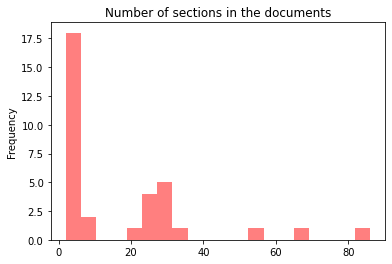

In [37]:
import pandas as pd

df = pd.DataFrame(listStats, columns=['Filename', 'Sections'])

# plot the data
import matplotlib.pyplot as plt

df['Sections'].plot(kind='hist', bins=20, alpha=0.5, color='r', title='Number of sections in the documents')